In [1]:
#import libraries
!pip3 install --user sklearn
!pip3 install --user pandas
!pip3 install --user keras tensorflow
!pip3 install --user keras==2.3.0
!pip3 install --user seaborn
#import sklearn

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing

import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
# set matplotlib to display all plots inline with the notebook
#!pip install keras
#import keras
from keras.datasets import mnist
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, Lambda, Activation, ZeroPadding2D
from keras.models import Model, Sequential

import os
import tensorflow as tf
from tensorflow import keras

#from dummyPy import OneHotEncoder

import keras.backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Using TensorFlow backend.


### Preparing data subsets for initial model fitting

 - Consistent with Alara's method and Chloe's clean-up functions
 - Possible difficulty in matching time of failure in results table to data files (use the nearest match)
 - Match data files with results table using the simulation ID in the filenames

In [2]:
import os

import pandas as pd
import numpy as np

results = pd.read_csv('processed_results_summary.csv', keep_default_na=False)
results.head(n = 3)


,Unnamed: 0,Simulation no#,Line,Load,Wind1,Wind2,Wind3,flag,Sequence,n_failures,t_fail,t_first_fail,dt_fail,failed component_type,failed_component_type,cascade,fail
0,0,1,Line 04 - 05,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
1,18,10,Line 26 - 28,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
2,198,100,Line 09 - 39,0.7,0.0,0.0,0.4,0,[],0,,,,,,False,False


In [3]:
from tensorflow import keras

In [4]:
keras.Sequential()

In [5]:
np.random.seed(seed = 17) # To select the same files as the LSTM model

# Get the simulation ids of sims with and without failures
fail_ids = results[results['flag'] == 1]['Simulation no#'].tolist()
non_fail_ids = results[results['flag'] == 0]['Simulation no#'].tolist()

# Randomly select 20 fail and 100 non-fail cases
fail_ids = np.random.choice(fail_ids, size = 20, replace = False)
non_fail_ids = np.random.choice(non_fail_ids, size = 100, replace = False)

print(len(non_fail_ids))

100


In [6]:
# List data files and read in the selected simulations
DATA_PATH = '/data/Data'
files = os.listdir(DATA_PATH)

In [7]:
def convert_objects_to_float(df):
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        df[col] = df[col].astype('float')
    return df

def add_NSG_columns_and_sort_columns_alphabetically(df):
    """
    Add NSG columns when missing from dataframe in order
    to get homogeneous set of columns in each dataframe.
    """
    cols_to_add = [('NSG_1', 'Active Power in MW'), ('NSG_1', 'Reactive Power in Mvar' ), ('NSG_2', 'Active Power in MW'), ('NSG_3', 'Active Power in MW')]
    for col in cols_to_add:
        if not col in df.columns:
            df[col] = '0'
    df = df.sort_index(axis = 1)
    return df

def load_data(filepath):
    df = pd.read_csv(filepath, sep = ',', header = [0,1])
    df = convert_objects_to_float(df)
    df = add_NSG_columns_and_sort_columns_alphabetically(df)
    df = df.droplevel(1, axis = 1) 
    return df

In [8]:
# Create a list of dataframes with the selected simulations

t_before_fail = 0.5 # How long before the first failure should we stop sampling?     (for failure cases)
t_begin = 1.07 # When should we start sampling?                                      (for all cases)

subset = []
for file in files:
    file_id = int(file.split('_')[0])
    if not file.endswith('results_cascs.csv'):
        
        if file_id in fail_ids:
            filepath = os.path.join(DATA_PATH, file)
            df = load_data(filepath)
            df['sim_num'] = file_id
            df['fail'] = 1
            
            # Exclude data prior to system perturbation and after 0.5 seconds before first failure
            t_fail = float(results[results['Simulation no#'] == file_id]['t_first_fail'].unique()[0])
            df = df.loc[(df['All calculations'] <= (t_fail - t_before_fail)) & (df['All calculations'] > t_begin)]

            subset.append(df)
            
        if file_id in non_fail_ids:
            filepath = os.path.join(DATA_PATH, file)
            df = load_data(filepath)
            df['sim_num'] = file_id
            df['fail'] = 0
            
            # Exclude data prior to system perturbation
            df = df.loc[(df['All calculations'] > t_begin)]
            
            subset.append(df)

Some checks:

In [9]:
min_ts = 0
#for df in subset:
#    print(df.shape)

min([df.shape[0] for df in subset])

162

### Train & Test Data

In [10]:
def get_window(dataset, start_index, length, shift=10):

  data = []
  end_index = len(dataset) - length

  for i in range(start_index, end_index, shift):
      data.append(dataset.iloc[i:length, :])

  return data

In [11]:
def get_window_LSTM(df, start_index, length, shift=25):
  x, y = [], []
  end_index = len(df) - length

  for i in range(start_index, end_index, shift):
      y.append(df.iloc[i:(i+length), 251].values[0])
      source = df.iloc[i:(i+length), :].drop(['All calculations', 'sim_num', 'fail'], axis=1)
      x.append(source.to_numpy())

  return x, y

In [12]:
subset[0]['All calculations'].values

array([  1.070222,   1.070232,   1.070248, ..., 119.933666, 119.969145,
       120.      ])

In [13]:
import joblib
import os
import pandas as pd
from typing import Dict, List
import numpy as np
from scipy import interpolate
import random
#import seaborn as sns
%matplotlib inline

def interpolation_reconstruction(df, ngrid = 3000): # default value for n_grid = 3000
    """
    Compute interpolated timestamp for each scenario.
    The interpolation is made on a regular grid of x-values spanning the same interval as during the simulation.

    Parameters
    ----------
    df : pd.DataFrame
        Simulation dataframe
    ngrid : int
        Number of x-values to span.
    """
    list_concat = []
    for col in df.columns[1:]:
        X = df['All calculations'].values                                             # X = df['All calculations', 'Time in s'].values
        y = df[col].values
        f = interpolate.interp1d(X, y)
        xgrid = np.linspace(X.min(), X.max(), ngrid)
        ygrid = f(xgrid)
        to_concat = pd.DataFrame({('All calculations'): xgrid, col: ygrid})           # to_concat = pd.DataFrame({('All calculations', 'Time in s'): xgrid, col: ygrid})
        list_concat.append(to_concat)
    dfs = [df.set_index(('All calculations')) for df in list_concat]                  # dfs = [df.set_index(('All calculations', 'Time in s')) for df in list_concat]
    interpolate_construction = pd.concat(dfs, axis=1)
    return interpolate_construction.reset_index()

In [14]:
for col in subset[0].columns[1:]:
    X = subset[0]['All calculations'].values
    y = subset[0][col].values
    #print(X.max()); print(X.min())
    #f = interpolate.interp1d(X, y)

#subset[0].head(n = 3)

In [15]:
import math

p_train = 0.8

n_train_non_fail = math.floor(len(non_fail_ids) * p_train)                             # The training set contains only non-failure cases
n_test_non_fail = len(non_fail_ids) - n_train_non_fail; n_test_fail = n_test_non_fail  # The test set has an equal number of failure and non-failure cases

train_ids = list(non_fail_ids[:n_train_non_fail])
test_ids = list(non_fail_ids[n_train_non_fail:]) + list(fail_ids)

train, test = [], []
#for df in subset:
#    if df['sim_num'].unique()[0] in train_ids:
#        #df = interpolation_reconstruction(df = df, ngrid = 3000)          # Interpoloation function not working after 2nd index was removed!
#        train.append(df.drop(['fail'], axis = 1))                         # Removing labels from training sets for autoencoder
#    else:
#        test.append(df)                                                   # Maintaining labels for test sets

        

#for df in subset:
#    if df['sim_num'].unique()[0] in train_ids:
#        train.append(get_window(dataset=df, start_index=0, length=100))
#    else:
#        test.append(get_window(dataset=df, start_index=0, length=100))
        
        
train_X, train_y = [], []
test_X, test_y = [], []

for df in subset:
    if df['sim_num'].unique()[0] in train_ids:
        x, y = get_window_LSTM(df=df, start_index=0, length=100)
        train_X.extend(x)
        train_y.extend(y)
    else:
        x, y = get_window_LSTM(df=df, start_index=0, length=100)
        test_X.extend(x)
        test_y.extend(y)

In [16]:
x_train_arrays = [np.asarray(df) for df in train_X]

x_test_arrays = [np.asarray(df) for df in test_X]
y_test_arrays = [np.asarray(df) for df in test_y]

x_train = np.asarray(x_train_arrays)
x_test = np.asarray(x_test_arrays)
y_test = np.asarray(y_test_arrays)

### Creating a validation set for the autoencoder as a subset of the training data

In [17]:
11675 * 0.8

9340.0

In [18]:
shape = x_train.shape[0]
print (shape)
x_train_new = x_train[:int(shape*0.8), :, :]   #we are splitting the first index (number of samples) into 80-20% split, the inner dim should remain the same
x_train_val = x_train[int(shape*0.8):, :, :]

print(x_train_new.shape)
print(x_train_val.shape)

11675
(9340, 100, 249)
(2335, 100, 249)


In [19]:
x_train_red = x_train_new[:, :, 1:]
x_val_red = x_train_val[:, :, 1:]
x_test_red = x_test[:, :, 1:]

print(x_train_red.shape)

(9340, 100, 248)


## Plotting the data as images (no failure, with failure)

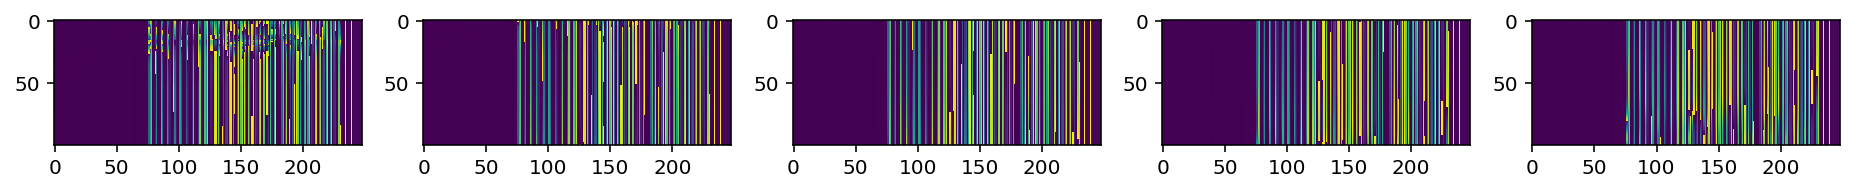

In [37]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img

fig, axes = plt.subplots(1,5, figsize=(16,16))
#images = array_to_img(x_train_red)
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_red[i].astype(np.uint8))

## Modelling starts here after the data is put into x_train, x_test, y_test

In [21]:
from keras.datasets import mnist

x_train = x_train_red.astype('float32') / 255.
x_val = x_val_red.astype('float32') / 255.
x_test = x_test_red.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

#x_train = x_train.reshape(x_train.shape + (1,))
#x_test = x_train.reshape(x_test.shape + (1,))
print (x_train.shape)
print (x_test.shape)
print (y_test.shape)

shape_x=100  #n_timesteps
shape_y=248  #n_features

(9340, 100, 248, 1)
(3106, 100, 248, 1)
(3106,)


In [22]:
#Get the threshold
def Threshold(losses_train, name):
    
    mean_mse = np.mean(losses_train)

    var_mse = np.var(losses_train)

    median_mse = np.median (losses_train)

    losses_min = np.min(losses_train)
    losses_max = np.max(losses_train)

    min_max = (losses_min + losses_max)/2


    std_mse = np.std(losses_train)
    std3 = 3*std_mse


    Q25 = np.percentile(losses_train, 25) #25th_percentile
    Q75 = np.percentile(losses_train, 75)#75th_percentile
    IQR = Q75 - Q25         #// inter-quartile range

    IQR_Q3 = Q75  + 1.5 * IQR
    meanIQR = mean_mse  + 1.5 * IQR
    medIQR = median_mse  + 1.5 * IQR

    mean_std = mean_mse + std_mse

    median_std = median_mse +std_mse

    if name=="mean":
        threshold = mean_mse
    elif name=="median":
        threshold = median_mse
    elif name == "meanIQR":
        threshold= meanIQR
    elif name == "meanstd":
    	threshold= mean_std
        
    elif name == "std3":
    	threshold= std3      
        
    elif name == "IQRq3":
        threshold= IQR_Q3

    elif name == "minmax":
        threshold= min_max
        
    return threshold
    

In [23]:
def mean_squared_loss(x1,x2):
    ''' Compute Euclidean Distance Loss  between 
    input frame and the reconstructed frame'''

    diff=x1-x2
    #print(diff.shape)
    a,b,c,d=diff.shape
    #print (diff.shape)
    #n_samples=a*b*c*d
    n_samples=a*b*c *d
    sq_diff=diff**2
    Sum=sq_diff.sum()
    dist=np.sqrt(Sum)
    mean_dist=dist/n_samples
    return mean_dist


In [24]:
#Instead of computing threshold outside the training, we will use a callback that returns the total losses
class AnomalyThresholdCallback(keras.callbacks.Callback):
    def __init__(self, autoencoder):
        self.losses_train =[]
        self.threshold = 0
        self.autoencoder = autoencoder
    def on_train_end(self, logs=None):
        for number, bunch in enumerate(x_train):
            #print ('x_train shape', bunch.shape)
            n_bunch=np.expand_dims(bunch,axis=0)
            #n_bunch=np.asarray(n_bunch).astype(np.float32)
            reconstructed_bunch=self.autoencoder.predict(n_bunch)
            #reconstructed_bunch=np.asarray(reconstructed_bunch).astype(np.float32) 
            loss_train=mean_squared_loss(n_bunch,reconstructed_bunch)
            self.losses_train.append(loss_train)
    
            #self.losses_train.append(autoencoder.predict(x_train))   #evaluates the model on entire training set
        #mean_mse = np.mean(self.losses_train)
        #self.threshold = mean_mse
        


In [25]:


def Autoencoder1 (shape_x=100, shape_y=248):
    input_img = Input(shape=(shape_x, shape_y, 1))

    # Encoding
    x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
    x = Conv2D(1,(3, 3), padding='same', activation='relu')(x)
    encoded = MaxPooling2D(pool_size=(2,2), padding='same')(x)

    # Decoding
    x = Conv2D(1,(3, 3), padding='same', activation='relu')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16,(3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1,(3, 2), padding='same')(x)
    #x= ZeroPadding2D(padding=1)(x)

    decoded = Activation('relu')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    return autoencoder

In [26]:
pretrain_epochs = 10
batch_size = 64

In [27]:
def AELearning (buffer):
    autoencoder = Autoencoder1()
    thresholding =  AnomalyThresholdCallback(autoencoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(buffer, buffer, batch_size=batch_size, epochs=pretrain_epochs, verbose=1, callbacks=[thresholding], validation_data=(x_val,x_val))#, cp_callback])
    losses_xtrain = thresholding.losses_train
    return  autoencoder,losses_xtrain

In [28]:
def AnomalyDetection(stream, autoencoder, threshold):
    losses_test = []
    y_pred = []
    for number,bunch in enumerate(stream):
        n_bunch=np.expand_dims(bunch,axis=0)
        reconstructed_bunch=autoencoder.predict(n_bunch)

        loss=mean_squared_loss(n_bunch,reconstructed_bunch)
        losses_test.append(loss)

        if loss > threshold:
            y = 1 #abnormal (failure cases)

        else:
            y = 0 #normal (non-failure cases)
        y_pred.append(y)
    return y_pred,losses_test

In [29]:
#model training
AEmodel, losses_xtrain = AELearning(x_train)  #this is where the autoencoder model works

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 248, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 246, 16)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 123, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 123, 1)        145       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 62, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 62, 1)         10        
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 124, 1)        0   

Train on 9340 samples, validate on 2335 samples
Epoch 1/10


  64/9340 [..............................] - ETA: 3:18 - loss: 0.5444

 128/9340 [..............................] - ETA: 2:20 - loss: 0.5315

 192/9340 [..............................] - ETA: 2:00 - loss: 0.5302

 256/9340 [..............................] - ETA: 1:49 - loss: 0.5236

 320/9340 [>.............................] - ETA: 1:44 - loss: 0.5211

 384/9340 [>.............................] - ETA: 1:39 - loss: 0.5191

 448/9340 [>.............................] - ETA: 1:36 - loss: 0.5203

 512/9340 [>.............................] - ETA: 1:33 - loss: 0.5205

 576/9340 [>.............................] - ETA: 1:31 - loss: 0.5210

 640/9340 [=>............................] - ETA: 1:29 - loss: 0.5186

 704/9340 [=>............................] - ETA: 1:27 - loss: 0.5184

 768/9340 [=>............................] - ETA: 1:26 - loss: 0.5181

 832/9340 [=>............................] - ETA: 1:24 - loss: 0.5176

 896/9340 [=>............................] - ETA: 1:23 - loss: 0.5158

 960/9340 [==>...........................] - ETA: 1:22 - loss: 0.5143

1024/9340 [==>...........................] - ETA: 1:21 - loss: 0.5128

1088/9340 [==>...........................] - ETA: 1:20 - loss: 0.5115

1152/9340 [==>...........................] - ETA: 1:19 - loss: 0.5121

1216/9340 [==>...........................] - ETA: 1:18 - loss: 0.5124

1280/9340 [===>..........................] - ETA: 1:17 - loss: 0.5136

1344/9340 [===>..........................] - ETA: 1:17 - loss: 0.5123

1408/9340 [===>..........................] - ETA: 1:16 - loss: 0.5115

1472/9340 [===>..........................] - ETA: 1:15 - loss: 0.5109

1536/9340 [===>..........................] - ETA: 1:14 - loss: 0.5105

1600/9340 [====>.........................] - ETA: 1:13 - loss: 0.5111

1664/9340 [====>.........................] - ETA: 1:12 - loss: 0.5106

1728/9340 [====>.........................] - ETA: 1:12 - loss: 0.5111

1792/9340 [====>.........................] - ETA: 1:11 - loss: 0.5101

1856/9340 [====>.........................] - ETA: 1:10 - loss: 0.5100

1920/9340 [=====>........................] - ETA: 1:09 - loss: 0.5095

1984/9340 [=====>........................] - ETA: 1:09 - loss: 0.5092

2048/9340 [=====>........................] - ETA: 1:08 - loss: 0.5094

2112/9340 [=====>........................] - ETA: 1:07 - loss: 0.5091

2176/9340 [=====>........................] - ETA: 1:07 - loss: 0.5082

2240/9340 [======>.......................] - ETA: 1:06 - loss: 0.5081

2304/9340 [======>.......................] - ETA: 1:05 - loss: 0.5075

2368/9340 [======>.......................] - ETA: 1:05 - loss: 0.5061

2432/9340 [======>.......................] - ETA: 1:04 - loss: 0.5057

2496/9340 [=======>......................] - ETA: 1:03 - loss: 0.5055

2560/9340 [=======>......................] - ETA: 1:03 - loss: 0.5057

2624/9340 [=======>......................] - ETA: 1:02 - loss: 0.5056

2688/9340 [=======>......................] - ETA: 1:01 - loss: 0.5058

2752/9340 [=======>......................] - ETA: 1:01 - loss: 0.5060

2816/9340 [========>.....................] - ETA: 1:00 - loss: 0.5055

2880/9340 [========>.....................] - ETA: 59s - loss: 0.5052 

2944/9340 [========>.....................] - ETA: 59s - loss: 0.5048

3008/9340 [========>.....................] - ETA: 58s - loss: 0.5051

3072/9340 [========>.....................] - ETA: 57s - loss: 0.5049

3136/9340 [=========>....................] - ETA: 57s - loss: 0.5049

3200/9340 [=========>....................] - ETA: 56s - loss: 0.5047

3264/9340 [=========>....................] - ETA: 56s - loss: 0.5047

3328/9340 [=========>....................] - ETA: 55s - loss: 0.5048

3392/9340 [=========>....................] - ETA: 54s - loss: 0.5045

3456/9340 [==========>...................] - ETA: 54s - loss: 0.5041

3520/9340 [==========>...................] - ETA: 53s - loss: 0.5043

3584/9340 [==========>...................] - ETA: 52s - loss: 0.5044

3648/9340 [==========>...................] - ETA: 52s - loss: 0.5042

3712/9340 [==========>...................] - ETA: 51s - loss: 0.5040

3776/9340 [===========>..................] - ETA: 51s - loss: 0.5038

3840/9340 [===========>..................] - ETA: 50s - loss: 0.5037

3904/9340 [===========>..................] - ETA: 49s - loss: 0.5036

3968/9340 [===========>..................] - ETA: 49s - loss: 0.5034

4032/9340 [===========>..................] - ETA: 48s - loss: 0.5034

4096/9340 [============>.................] - ETA: 48s - loss: 0.5032

4160/9340 [============>.................] - ETA: 47s - loss: 0.5028

4224/9340 [============>.................] - ETA: 46s - loss: 0.5026

4288/9340 [============>.................] - ETA: 46s - loss: 0.5026

4352/9340 [============>.................] - ETA: 45s - loss: 0.5025

4416/9340 [=============>................] - ETA: 45s - loss: 0.5022

4480/9340 [=============>................] - ETA: 44s - loss: 0.5023

4544/9340 [=============>................] - ETA: 43s - loss: 0.5022

4608/9340 [=============>................] - ETA: 43s - loss: 0.5024

4672/9340 [==============>...............] - ETA: 42s - loss: 0.5020

4736/9340 [==============>...............] - ETA: 42s - loss: 0.5016

4800/9340 [==============>...............] - ETA: 41s - loss: 0.5014

4864/9340 [==============>...............] - ETA: 40s - loss: 0.5015

4928/9340 [==============>...............] - ETA: 40s - loss: 0.5014

4992/9340 [===============>..............] - ETA: 39s - loss: 0.5012

5056/9340 [===============>..............] - ETA: 39s - loss: 0.5008

5120/9340 [===============>..............] - ETA: 38s - loss: 0.5007

5184/9340 [===============>..............] - ETA: 37s - loss: 0.5006

5248/9340 [===============>..............] - ETA: 37s - loss: 0.5006

5312/9340 [================>.............] - ETA: 36s - loss: 0.5005

5376/9340 [================>.............] - ETA: 36s - loss: 0.5003

5440/9340 [================>.............] - ETA: 35s - loss: 0.5006

5504/9340 [================>.............] - ETA: 35s - loss: 0.5005

5568/9340 [================>.............] - ETA: 34s - loss: 0.5005

5632/9340 [=================>............] - ETA: 33s - loss: 0.5004

5696/9340 [=================>............] - ETA: 33s - loss: 0.5000

5760/9340 [=================>............] - ETA: 32s - loss: 0.4998

5824/9340 [=================>............] - ETA: 32s - loss: 0.4993

5888/9340 [=================>............] - ETA: 31s - loss: 0.4993

5952/9340 [==================>...........] - ETA: 30s - loss: 0.4990

6016/9340 [==================>...........] - ETA: 30s - loss: 0.4987

6080/9340 [==================>...........] - ETA: 29s - loss: 0.4984

6144/9340 [==================>...........] - ETA: 29s - loss: 0.4981

6208/9340 [==================>...........] - ETA: 28s - loss: 0.4979

6272/9340 [===================>..........] - ETA: 27s - loss: 0.4975

6336/9340 [===================>..........] - ETA: 27s - loss: 0.4972

6400/9340 [===================>..........] - ETA: 26s - loss: 0.4970

6464/9340 [===================>..........] - ETA: 26s - loss: 0.4966

6528/9340 [===================>..........] - ETA: 25s - loss: 0.4964

6592/9340 [====================>.........] - ETA: 25s - loss: 0.4959

6656/9340 [====================>.........] - ETA: 24s - loss: 0.4957

6720/9340 [====================>.........] - ETA: 23s - loss: 0.4952

6784/9340 [====================>.........] - ETA: 23s - loss: 0.4948

6848/9340 [====================>.........] - ETA: 22s - loss: 0.4943

6912/9340 [=====================>........] - ETA: 22s - loss: 0.4937

6976/9340 [=====================>........] - ETA: 21s - loss: 0.4931

7040/9340 [=====================>........] - ETA: 20s - loss: 0.4926

7104/9340 [=====================>........] - ETA: 20s - loss: 0.4921

7168/9340 [======================>.......] - ETA: 19s - loss: 0.4916

7232/9340 [======================>.......] - ETA: 19s - loss: 0.4911

7296/9340 [======================>.......] - ETA: 18s - loss: 0.4905

7360/9340 [======================>.......] - ETA: 18s - loss: 0.4899

7424/9340 [======================>.......] - ETA: 17s - loss: 0.4894

7488/9340 [=======================>......] - ETA: 16s - loss: 0.4888

7552/9340 [=======================>......] - ETA: 16s - loss: 0.4882

7616/9340 [=======================>......] - ETA: 15s - loss: 0.4877

7680/9340 [=======================>......] - ETA: 15s - loss: 0.4872

7744/9340 [=======================>......] - ETA: 14s - loss: 0.4867

7808/9340 [========================>.....] - ETA: 13s - loss: 0.4863

7872/9340 [========================>.....] - ETA: 13s - loss: 0.4857

7936/9340 [========================>.....] - ETA: 12s - loss: 0.4853

8000/9340 [========================>.....] - ETA: 12s - loss: 0.4848

8064/9340 [========================>.....] - ETA: 11s - loss: 0.4842

8128/9340 [=========================>....] - ETA: 11s - loss: 0.4836

8192/9340 [=========================>....] - ETA: 10s - loss: 0.4831

8256/9340 [=========================>....] - ETA: 9s - loss: 0.4828 

8320/9340 [=========================>....] - ETA: 9s - loss: 0.4823

8384/9340 [=========================>....] - ETA: 8s - loss: 0.4818

8448/9340 [==========================>...] - ETA: 8s - loss: 0.4814

8512/9340 [==========================>...] - ETA: 7s - loss: 0.4808

8576/9340 [==========================>...] - ETA: 6s - loss: 0.4804

8640/9340 [==========================>...] - ETA: 6s - loss: 0.4800

8704/9340 [==========================>...] - ETA: 5s - loss: 0.4797

8768/9340 [===========================>..] - ETA: 5s - loss: 0.4791

8832/9340 [===========================>..] - ETA: 4s - loss: 0.4787

8896/9340 [===========================>..] - ETA: 4s - loss: 0.4782

8960/9340 [===========================>..] - ETA: 3s - loss: 0.4778

9024/9340 [===========================>..] - ETA: 2s - loss: 0.4773

9088/9340 [============================>.] - ETA: 2s - loss: 0.4768

9152/9340 [============================>.] - ETA: 1s - loss: 0.4764

9216/9340 [============================>.] - ETA: 1s - loss: 0.4760

9280/9340 [============================>.] - ETA: 0s - loss: 0.4756

9340/9340 [==============================] - 91s 10ms/step - loss: 0.4752 - val_loss: 0.3618


Epoch 2/10


  64/9340 [..............................] - ETA: 1:24 - loss: 0.4292

 128/9340 [..............................] - ETA: 1:25 - loss: 0.4170

 192/9340 [..............................] - ETA: 1:24 - loss: 0.4156

 256/9340 [..............................] - ETA: 1:23 - loss: 0.4075

 320/9340 [>.............................] - ETA: 1:22 - loss: 0.4054

 384/9340 [>.............................] - ETA: 1:22 - loss: 0.4025

 448/9340 [>.............................] - ETA: 1:23 - loss: 0.4048

 512/9340 [>.............................] - ETA: 1:23 - loss: 0.4044

 576/9340 [>.............................] - ETA: 1:23 - loss: 0.4013

 640/9340 [=>............................] - ETA: 1:21 - loss: 0.4001

 704/9340 [=>............................] - ETA: 1:21 - loss: 0.4010

 768/9340 [=>............................] - ETA: 1:20 - loss: 0.4006

 832/9340 [=>............................] - ETA: 1:19 - loss: 0.4007

 896/9340 [=>............................] - ETA: 1:18 - loss: 0.4007

 960/9340 [==>...........................] - ETA: 1:18 - loss: 0.4011

1024/9340 [==>...........................] - ETA: 1:17 - loss: 0.4009

1088/9340 [==>...........................] - ETA: 1:16 - loss: 0.4008

1152/9340 [==>...........................] - ETA: 1:15 - loss: 0.4007

1216/9340 [==>...........................] - ETA: 1:15 - loss: 0.3999

1280/9340 [===>..........................] - ETA: 1:14 - loss: 0.3992

1344/9340 [===>..........................] - ETA: 1:14 - loss: 0.3990

1408/9340 [===>..........................] - ETA: 1:13 - loss: 0.3978

1472/9340 [===>..........................] - ETA: 1:12 - loss: 0.3971

1536/9340 [===>..........................] - ETA: 1:11 - loss: 0.3965

1600/9340 [====>.........................] - ETA: 1:11 - loss: 0.3959

1664/9340 [====>.........................] - ETA: 1:10 - loss: 0.3959

1728/9340 [====>.........................] - ETA: 1:09 - loss: 0.3953

1792/9340 [====>.........................] - ETA: 1:09 - loss: 0.3950

1856/9340 [====>.........................] - ETA: 1:08 - loss: 0.3955

1920/9340 [=====>........................] - ETA: 1:07 - loss: 0.3955

1984/9340 [=====>........................] - ETA: 1:07 - loss: 0.3959

2048/9340 [=====>........................] - ETA: 1:06 - loss: 0.3960

2112/9340 [=====>........................] - ETA: 1:06 - loss: 0.3960

2176/9340 [=====>........................] - ETA: 1:05 - loss: 0.3959

2240/9340 [======>.......................] - ETA: 1:04 - loss: 0.3958

2304/9340 [======>.......................] - ETA: 1:04 - loss: 0.3958

2368/9340 [======>.......................] - ETA: 1:03 - loss: 0.3960

2432/9340 [======>.......................] - ETA: 1:02 - loss: 0.3959

2496/9340 [=======>......................] - ETA: 1:02 - loss: 0.3957

2560/9340 [=======>......................] - ETA: 1:01 - loss: 0.3955

2624/9340 [=======>......................] - ETA: 1:01 - loss: 0.3960

2688/9340 [=======>......................] - ETA: 1:00 - loss: 0.3952

2752/9340 [=======>......................] - ETA: 1:00 - loss: 0.3948

2816/9340 [========>.....................] - ETA: 59s - loss: 0.3948 

2880/9340 [========>.....................] - ETA: 58s - loss: 0.3947

2944/9340 [========>.....................] - ETA: 58s - loss: 0.3943

3008/9340 [========>.....................] - ETA: 57s - loss: 0.3944

3072/9340 [========>.....................] - ETA: 57s - loss: 0.3944

3136/9340 [=========>....................] - ETA: 56s - loss: 0.3941

3200/9340 [=========>....................] - ETA: 55s - loss: 0.3937

3264/9340 [=========>....................] - ETA: 55s - loss: 0.3935

3328/9340 [=========>....................] - ETA: 55s - loss: 0.3936

3392/9340 [=========>....................] - ETA: 54s - loss: 0.3935

3456/9340 [==========>...................] - ETA: 53s - loss: 0.3935

3520/9340 [==========>...................] - ETA: 53s - loss: 0.3932

3584/9340 [==========>...................] - ETA: 52s - loss: 0.3932

3648/9340 [==========>...................] - ETA: 52s - loss: 0.3931

3712/9340 [==========>...................] - ETA: 51s - loss: 0.3929

3776/9340 [===========>..................] - ETA: 51s - loss: 0.3929

3840/9340 [===========>..................] - ETA: 50s - loss: 0.3926

3904/9340 [===========>..................] - ETA: 49s - loss: 0.3924

3968/9340 [===========>..................] - ETA: 49s - loss: 0.3924

4032/9340 [===========>..................] - ETA: 48s - loss: 0.3921

4096/9340 [============>.................] - ETA: 48s - loss: 0.3920

4160/9340 [============>.................] - ETA: 47s - loss: 0.3916

4224/9340 [============>.................] - ETA: 46s - loss: 0.3915

4288/9340 [============>.................] - ETA: 46s - loss: 0.3913

4352/9340 [============>.................] - ETA: 45s - loss: 0.3912

4416/9340 [=============>................] - ETA: 45s - loss: 0.3910

4480/9340 [=============>................] - ETA: 44s - loss: 0.3908

4544/9340 [=============>................] - ETA: 43s - loss: 0.3906

4608/9340 [=============>................] - ETA: 43s - loss: 0.3908

4672/9340 [==============>...............] - ETA: 42s - loss: 0.3904

4736/9340 [==============>...............] - ETA: 42s - loss: 0.3903

4800/9340 [==============>...............] - ETA: 41s - loss: 0.3903

4864/9340 [==============>...............] - ETA: 40s - loss: 0.3902

4928/9340 [==============>...............] - ETA: 40s - loss: 0.3899

4992/9340 [===============>..............] - ETA: 39s - loss: 0.3897

5056/9340 [===============>..............] - ETA: 39s - loss: 0.3896

5120/9340 [===============>..............] - ETA: 38s - loss: 0.3897

5184/9340 [===============>..............] - ETA: 37s - loss: 0.3896

5248/9340 [===============>..............] - ETA: 37s - loss: 0.3894

5312/9340 [================>.............] - ETA: 36s - loss: 0.3892

5376/9340 [================>.............] - ETA: 36s - loss: 0.3887

5440/9340 [================>.............] - ETA: 35s - loss: 0.3887

5504/9340 [================>.............] - ETA: 34s - loss: 0.3885

5568/9340 [================>.............] - ETA: 34s - loss: 0.3884

5632/9340 [=================>............] - ETA: 33s - loss: 0.3880

5696/9340 [=================>............] - ETA: 33s - loss: 0.3878

5760/9340 [=================>............] - ETA: 32s - loss: 0.3877

5824/9340 [=================>............] - ETA: 32s - loss: 0.3875

5888/9340 [=================>............] - ETA: 31s - loss: 0.3874

5952/9340 [==================>...........] - ETA: 30s - loss: 0.3872

6016/9340 [==================>...........] - ETA: 30s - loss: 0.3871

6080/9340 [==================>...........] - ETA: 29s - loss: 0.3870

6144/9340 [==================>...........] - ETA: 29s - loss: 0.3867

6208/9340 [==================>...........] - ETA: 28s - loss: 0.3866

6272/9340 [===================>..........] - ETA: 27s - loss: 0.3865

6336/9340 [===================>..........] - ETA: 27s - loss: 0.3863

6400/9340 [===================>..........] - ETA: 26s - loss: 0.3863

6464/9340 [===================>..........] - ETA: 26s - loss: 0.3862

6528/9340 [===================>..........] - ETA: 25s - loss: 0.3860

6592/9340 [====================>.........] - ETA: 24s - loss: 0.3857

6656/9340 [====================>.........] - ETA: 24s - loss: 0.3855

6720/9340 [====================>.........] - ETA: 23s - loss: 0.3853

6784/9340 [====================>.........] - ETA: 23s - loss: 0.3850

6848/9340 [====================>.........] - ETA: 22s - loss: 0.3850

6912/9340 [=====================>........] - ETA: 22s - loss: 0.3850

6976/9340 [=====================>........] - ETA: 21s - loss: 0.3849

7040/9340 [=====================>........] - ETA: 20s - loss: 0.3848

7104/9340 [=====================>........] - ETA: 20s - loss: 0.3846

7168/9340 [======================>.......] - ETA: 19s - loss: 0.3844

7232/9340 [======================>.......] - ETA: 19s - loss: 0.3846

7296/9340 [======================>.......] - ETA: 18s - loss: 0.3846

7360/9340 [======================>.......] - ETA: 17s - loss: 0.3845

7424/9340 [======================>.......] - ETA: 17s - loss: 0.3844

7488/9340 [=======================>......] - ETA: 16s - loss: 0.3845

7552/9340 [=======================>......] - ETA: 16s - loss: 0.3843

7616/9340 [=======================>......] - ETA: 15s - loss: 0.3842

7680/9340 [=======================>......] - ETA: 15s - loss: 0.3841

7744/9340 [=======================>......] - ETA: 14s - loss: 0.3840

7808/9340 [========================>.....] - ETA: 13s - loss: 0.3839

7872/9340 [========================>.....] - ETA: 13s - loss: 0.3837

7936/9340 [========================>.....] - ETA: 12s - loss: 0.3834

8000/9340 [========================>.....] - ETA: 12s - loss: 0.3833

8064/9340 [========================>.....] - ETA: 11s - loss: 0.3833

8128/9340 [=========================>....] - ETA: 10s - loss: 0.3832

8192/9340 [=========================>....] - ETA: 10s - loss: 0.3831

8256/9340 [=========================>....] - ETA: 9s - loss: 0.3829 

8320/9340 [=========================>....] - ETA: 9s - loss: 0.3828

8384/9340 [=========================>....] - ETA: 8s - loss: 0.3827

8448/9340 [==========================>...] - ETA: 8s - loss: 0.3827

8512/9340 [==========================>...] - ETA: 7s - loss: 0.3827

8576/9340 [==========================>...] - ETA: 6s - loss: 0.3825

8640/9340 [==========================>...] - ETA: 6s - loss: 0.3825

8704/9340 [==========================>...] - ETA: 5s - loss: 0.3825

8768/9340 [===========================>..] - ETA: 5s - loss: 0.3825

8832/9340 [===========================>..] - ETA: 4s - loss: 0.3821

8896/9340 [===========================>..] - ETA: 4s - loss: 0.3821

8960/9340 [===========================>..] - ETA: 3s - loss: 0.3820

9024/9340 [===========================>..] - ETA: 2s - loss: 0.3819

9088/9340 [============================>.] - ETA: 2s - loss: 0.3819

9152/9340 [============================>.] - ETA: 1s - loss: 0.3818

9216/9340 [============================>.] - ETA: 1s - loss: 0.3817

9280/9340 [============================>.] - ETA: 0s - loss: 0.3815

9340/9340 [==============================] - 90s 10ms/step - loss: 0.3815 - val_loss: 0.3368


Epoch 3/10


  64/9340 [..............................] - ETA: 1:26 - loss: 0.3723

 128/9340 [..............................] - ETA: 1:26 - loss: 0.3723

 192/9340 [..............................] - ETA: 1:24 - loss: 0.3710

 256/9340 [..............................] - ETA: 1:22 - loss: 0.3709

 320/9340 [>.............................] - ETA: 1:21 - loss: 0.3716

 384/9340 [>.............................] - ETA: 1:20 - loss: 0.3711

 448/9340 [>.............................] - ETA: 1:19 - loss: 0.3694

 512/9340 [>.............................] - ETA: 1:19 - loss: 0.3671

 576/9340 [>.............................] - ETA: 1:18 - loss: 0.3657

 640/9340 [=>............................] - ETA: 1:17 - loss: 0.3678

 704/9340 [=>............................] - ETA: 1:17 - loss: 0.3689

 768/9340 [=>............................] - ETA: 1:16 - loss: 0.3697

 832/9340 [=>............................] - ETA: 1:16 - loss: 0.3700

 896/9340 [=>............................] - ETA: 1:15 - loss: 0.3693

 960/9340 [==>...........................] - ETA: 1:15 - loss: 0.3689

1024/9340 [==>...........................] - ETA: 1:14 - loss: 0.3681

1088/9340 [==>...........................] - ETA: 1:14 - loss: 0.3680

1152/9340 [==>...........................] - ETA: 1:13 - loss: 0.3680

1216/9340 [==>...........................] - ETA: 1:13 - loss: 0.3679

1280/9340 [===>..........................] - ETA: 1:12 - loss: 0.3677

1344/9340 [===>..........................] - ETA: 1:11 - loss: 0.3677

1408/9340 [===>..........................] - ETA: 1:11 - loss: 0.3677

1472/9340 [===>..........................] - ETA: 1:10 - loss: 0.3673

1536/9340 [===>..........................] - ETA: 1:10 - loss: 0.3675

1600/9340 [====>.........................] - ETA: 1:09 - loss: 0.3671

1664/9340 [====>.........................] - ETA: 1:08 - loss: 0.3671

1728/9340 [====>.........................] - ETA: 1:08 - loss: 0.3675

1792/9340 [====>.........................] - ETA: 1:07 - loss: 0.3674

1856/9340 [====>.........................] - ETA: 1:07 - loss: 0.3669

1920/9340 [=====>........................] - ETA: 1:06 - loss: 0.3665

1984/9340 [=====>........................] - ETA: 1:05 - loss: 0.3662

2048/9340 [=====>........................] - ETA: 1:05 - loss: 0.3656

2112/9340 [=====>........................] - ETA: 1:04 - loss: 0.3654

2176/9340 [=====>........................] - ETA: 1:04 - loss: 0.3654

2240/9340 [======>.......................] - ETA: 1:03 - loss: 0.3658

2304/9340 [======>.......................] - ETA: 1:02 - loss: 0.3657

2368/9340 [======>.......................] - ETA: 1:02 - loss: 0.3657

2432/9340 [======>.......................] - ETA: 1:01 - loss: 0.3653

2496/9340 [=======>......................] - ETA: 1:01 - loss: 0.3651

2560/9340 [=======>......................] - ETA: 1:00 - loss: 0.3649

2624/9340 [=======>......................] - ETA: 1:00 - loss: 0.3649

2688/9340 [=======>......................] - ETA: 59s - loss: 0.3648 

2752/9340 [=======>......................] - ETA: 59s - loss: 0.3646

2816/9340 [========>.....................] - ETA: 58s - loss: 0.3648

2880/9340 [========>.....................] - ETA: 58s - loss: 0.3646

2944/9340 [========>.....................] - ETA: 57s - loss: 0.3646

3008/9340 [========>.....................] - ETA: 56s - loss: 0.3646

3072/9340 [========>.....................] - ETA: 56s - loss: 0.3647

3136/9340 [=========>....................] - ETA: 55s - loss: 0.3645

3200/9340 [=========>....................] - ETA: 55s - loss: 0.3644

3264/9340 [=========>....................] - ETA: 54s - loss: 0.3647

3328/9340 [=========>....................] - ETA: 53s - loss: 0.3646

3392/9340 [=========>....................] - ETA: 53s - loss: 0.3646

3456/9340 [==========>...................] - ETA: 52s - loss: 0.3645

3520/9340 [==========>...................] - ETA: 52s - loss: 0.3643

3584/9340 [==========>...................] - ETA: 51s - loss: 0.3640

3648/9340 [==========>...................] - ETA: 51s - loss: 0.3637

3712/9340 [==========>...................] - ETA: 50s - loss: 0.3635

3776/9340 [===========>..................] - ETA: 49s - loss: 0.3633

3840/9340 [===========>..................] - ETA: 49s - loss: 0.3629

3904/9340 [===========>..................] - ETA: 48s - loss: 0.3628

3968/9340 [===========>..................] - ETA: 48s - loss: 0.3627

4032/9340 [===========>..................] - ETA: 47s - loss: 0.3628

4096/9340 [============>.................] - ETA: 47s - loss: 0.3628

4160/9340 [============>.................] - ETA: 46s - loss: 0.3627

4224/9340 [============>.................] - ETA: 45s - loss: 0.3624

4288/9340 [============>.................] - ETA: 45s - loss: 0.3624

4352/9340 [============>.................] - ETA: 44s - loss: 0.3624

4416/9340 [=============>................] - ETA: 44s - loss: 0.3623

4480/9340 [=============>................] - ETA: 43s - loss: 0.3620

4544/9340 [=============>................] - ETA: 43s - loss: 0.3621

4608/9340 [=============>................] - ETA: 42s - loss: 0.3619

4672/9340 [==============>...............] - ETA: 41s - loss: 0.3620

4736/9340 [==============>...............] - ETA: 41s - loss: 0.3618

4800/9340 [==============>...............] - ETA: 40s - loss: 0.3619

4864/9340 [==============>...............] - ETA: 40s - loss: 0.3618

4928/9340 [==============>...............] - ETA: 39s - loss: 0.3617

4992/9340 [===============>..............] - ETA: 39s - loss: 0.3618

5056/9340 [===============>..............] - ETA: 38s - loss: 0.3616

5120/9340 [===============>..............] - ETA: 37s - loss: 0.3615

5184/9340 [===============>..............] - ETA: 37s - loss: 0.3615

5248/9340 [===============>..............] - ETA: 36s - loss: 0.3612

5312/9340 [================>.............] - ETA: 36s - loss: 0.3611

5376/9340 [================>.............] - ETA: 35s - loss: 0.3611

5440/9340 [================>.............] - ETA: 35s - loss: 0.3613

5504/9340 [================>.............] - ETA: 34s - loss: 0.3613

5568/9340 [================>.............] - ETA: 34s - loss: 0.3614

5632/9340 [=================>............] - ETA: 33s - loss: 0.3614

5696/9340 [=================>............] - ETA: 32s - loss: 0.3612

5760/9340 [=================>............] - ETA: 32s - loss: 0.3610

5824/9340 [=================>............] - ETA: 31s - loss: 0.3609

5888/9340 [=================>............] - ETA: 31s - loss: 0.3609

5952/9340 [==================>...........] - ETA: 30s - loss: 0.3609

6016/9340 [==================>...........] - ETA: 30s - loss: 0.3609

6080/9340 [==================>...........] - ETA: 29s - loss: 0.3609

6144/9340 [==================>...........] - ETA: 28s - loss: 0.3608

6208/9340 [==================>...........] - ETA: 28s - loss: 0.3608

6272/9340 [===================>..........] - ETA: 27s - loss: 0.3608

6336/9340 [===================>..........] - ETA: 27s - loss: 0.3607

6400/9340 [===================>..........] - ETA: 26s - loss: 0.3606

6464/9340 [===================>..........] - ETA: 26s - loss: 0.3606

6528/9340 [===================>..........] - ETA: 25s - loss: 0.3606

6592/9340 [====================>.........] - ETA: 24s - loss: 0.3606

6656/9340 [====================>.........] - ETA: 24s - loss: 0.3605

6720/9340 [====================>.........] - ETA: 23s - loss: 0.3606

6784/9340 [====================>.........] - ETA: 23s - loss: 0.3606

6848/9340 [====================>.........] - ETA: 22s - loss: 0.3605

6912/9340 [=====================>........] - ETA: 21s - loss: 0.3606

6976/9340 [=====================>........] - ETA: 21s - loss: 0.3606

7040/9340 [=====================>........] - ETA: 20s - loss: 0.3607

7104/9340 [=====================>........] - ETA: 20s - loss: 0.3605

7168/9340 [======================>.......] - ETA: 19s - loss: 0.3604

7232/9340 [======================>.......] - ETA: 19s - loss: 0.3605

7296/9340 [======================>.......] - ETA: 18s - loss: 0.3605

7360/9340 [======================>.......] - ETA: 17s - loss: 0.3605

7424/9340 [======================>.......] - ETA: 17s - loss: 0.3605

7488/9340 [=======================>......] - ETA: 16s - loss: 0.3603

7552/9340 [=======================>......] - ETA: 16s - loss: 0.3602

7616/9340 [=======================>......] - ETA: 15s - loss: 0.3602

7680/9340 [=======================>......] - ETA: 15s - loss: 0.3601

7744/9340 [=======================>......] - ETA: 14s - loss: 0.3600

7808/9340 [========================>.....] - ETA: 13s - loss: 0.3599

7872/9340 [========================>.....] - ETA: 13s - loss: 0.3599

7936/9340 [========================>.....] - ETA: 12s - loss: 0.3598

8000/9340 [========================>.....] - ETA: 12s - loss: 0.3597

8064/9340 [========================>.....] - ETA: 11s - loss: 0.3597

/projects/c5d23027-0a26-4603-a63f-4bb21ba0a554/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Reconstruction errors on the train set')

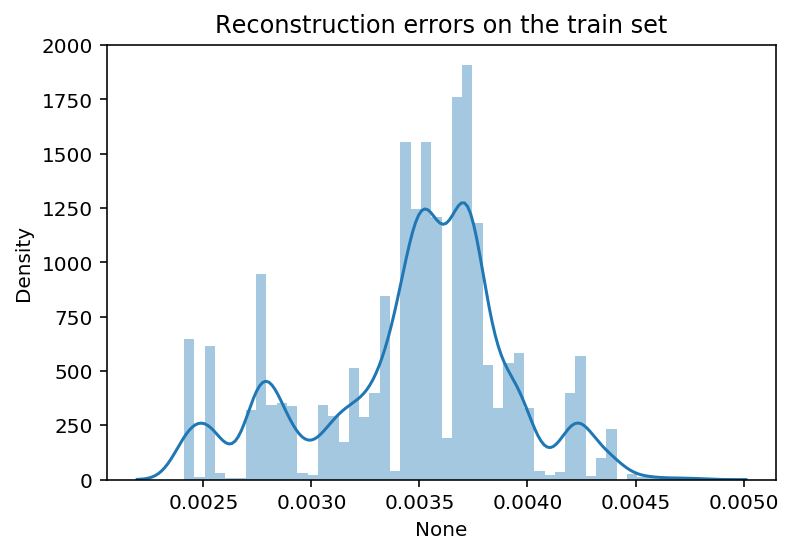

In [30]:
threshold = Threshold (losses_xtrain, "mean")
sns.distplot(losses_xtrain).set_title('Reconstruction errors on the train set')

In [31]:
print (threshold)

0.0034738286750507826


/projects/c5d23027-0a26-4603-a63f-4bb21ba0a554/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Reconstruction errors on the test set')

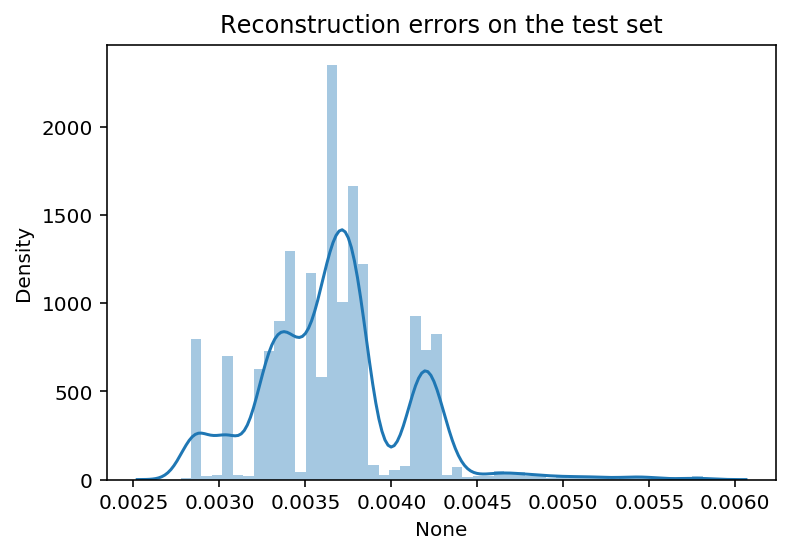

In [32]:
#threshold = 0.01
#y_pred= AnomalyDetection(x_test, trained_AE, threshold)  #to collect all values of y_pred as a bunch
y_pred, losses_test = AnomalyDetection(x_test, AEmodel, threshold)
sns.distplot(losses_test).set_title('Reconstruction errors on the test set')



In [33]:
accuracy = accuracy_score(y_test, y_pred)
print ('Accuracy on test set:,{:.3f}'.format(accuracy))
print (classification_report(y_test, y_pred))

Accuracy on test set:,0.346
              precision    recall  f1-score   support

           0       0.97      0.32      0.48      2942
           1       0.06      0.80      0.11       164

    accuracy                           0.35      3106
   macro avg       0.51      0.56      0.30      3106
weighted avg       0.92      0.35      0.46      3106



In [35]:
threshold_list = ["mean","median", "meanIQR", "meanstd", "std3","IQRq3","minmax"]

for i in threshold_list:
    threshold = Threshold (losses_xtrain, i)
    y_pred, losses_xtest = AnomalyDetection(x_test, AEmodel, threshold)
    accuracy = accuracy_score(y_test, y_pred)
    print (threshold)
    print (i+ ' threshold accuracy on test set:, {:.3f}'.format(accuracy))

0.0034738286750507826
mean threshold accuracy on test set:, 0.346


0.003550533171622984
median threshold accuracy on test set:, 0.411


0.004188543586727004
meanIQR threshold accuracy on test set:, 0.884


0.003923531189337897
meanstd threshold accuracy on test set:, 0.817


0.0013491075428613427
std3 threshold accuracy on test set:, 0.053


0.0044521427154541006
IQRq3 threshold accuracy on test set:, 0.969


0.003602328915749827
minmax threshold accuracy on test set:, 0.446
